# Validation of NISAR Requirement L2-SCI-667:  </br>Ice sheet and glacier velocity measurement - slow deformation
---

## Introduction
This notebook documents and executes a process to validate the NISAR slow ice deformation requirement (L2-SCI-667), which is specified as:

*The NISAR Project shall measure ice sheet (> 90% coverage, including both poles) and glaciers and ice-caps (> 80% coverage) horizontal velocity each cold season to an accuracy
 better than the sum of 3% of the horizontal velocity magnitude and 1 m/yr (1-sigma), at 100-m resolution in areas of slow deformation (< 50 m/yr).
 
As described below this process amounts to comparing L3 velocity products generated as described in the NISAR ATBD with points of known velocity and elevations. Specifically, the Cal/Val points will consist of:
* Zero velocity points on exposed bedrock; and
* On-ice GPS measurements of ice flow speed ($v_x$,$v_y$) and elevation ($z$).

The mean ($\mu_x$ and $\mu_y$) and standard deviations ($\sigma_x$ and $\sigma_y$) of the difference are used to determine the errors and whether those meet the requirements.

## Validation process
Standard statistical measurements as described below will be used to determine whether the requirement has been met.

### Setup
Import necessary libraries. The `nisarfunc` library can be found at https://github.com/fastice/nisarfunc.

In [1]:
import nisarfunc as n
import matplotlib.pylab as plt 
from IPython.display import Markdown as md

The `nisarfunc` package contains two main classes. 
* `nisarVel` to read and interpolate L3 nisar velocity products.
* `cvPoints` to read, filter, and analyse cal/val points in conjunction with velocity data.</br>

Start by creating an instance of `nisarVel` to read in an L3 velocity product. This example uses a GIMP annual geotiff product, which has seperate geotiff files for each velocity ($v_x$ and $v_y$) and 1-sigma error ($e_x$ and $e_y$) component. Readers for other products (i.e., UCI and JPL will be added).

In [2]:
myVel = n.nisarVel()
myVel.readDataFromTiff(
    'testData/Vel-2015-01-01.2015-12-31/release//GL_vel_mosaic_Annual_01Jan15_31Dec15_*_v02.0')

read time 0:00:04.051020
read time 0:00:03.690272


Next, create `cvPoints` object and read in the list of cal/val points.

In [3]:
myCVPts = n.cvPoints(cvFile='testData/TiepointsGL.ll.culled')

The format for this for this file is ASCII lines with 6 columns :</br>
; comment lines </br>
$lat$ $lon$ $z$ $v_x$ $v_y$ $v_z$</br>
$...$

For the analysis described here, we break the cal/val points into 3 groups:
* bed rock points in blue ($0 \leq \left|\vec{v}\right| < 0.01$ m/yr);
* slow moving interior points in red  ($0.01 \leq \left|\vec{v}\right| < 20$ m/yr); and
* faster moving points in yellow ($\left|\vec{v}\right| \geq 20$ m/yr).

These locations can be plotted over the velocity map by specifying the appropriate ranges as follows, with points in range 

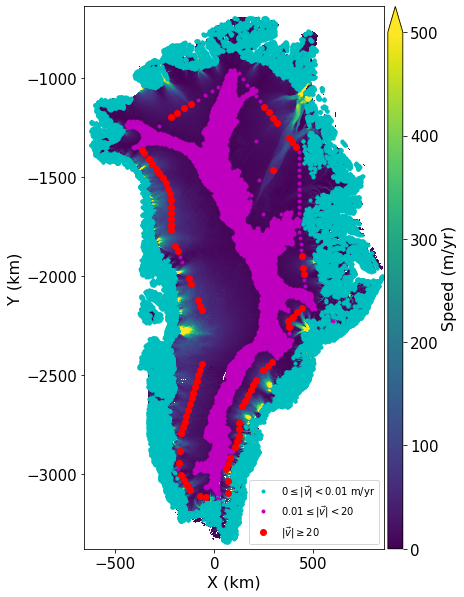

In [4]:
figV,axImage=myVel.displayVel()
myCVPts.plotVRangeCVLocs(0, 0.01, vel=myVel, ax=axImage, color='c', marker='.',
                         label='$0 \\leq \\left|\\vec{v} \\right| < 0.01$ m/yr')
myCVPts.plotVRangeCVLocs(0.01, 20, vel=myVel, ax=axImage, color='m', marker='.',
                         label='$0.01 \\leq \\left| \\vec{v} \\right| < 20$')
myCVPts.plotVRangeCVLocs(20, 1000, vel=myVel, ax=axImage, color='r', marker='.',
                         label='$\\left|\\vec{v}\\right| \\geq 20$',markersize=12)
axImage.legend()

**Figure 1. Map of speed with cal/val points as described above. Velocity map saturates at ~500 m/yr to show slower moving features.**

### Computation of Errors 

Errors are evaluated as the means ($\mu_x,\mu_y$), standard deviations ($\sigma_x,\sigma_y$), and root-mean-squares (rms) of the diferences between the measured velocity ($u_x,u_y$) and the cal/val points ($v_x,v_y$). Explicitly, these calculations are:

$\bar{\mu}_x = \frac{1}{N_{pts}}\sum \limits_{i=1}^{N_{pts}} (u_x-v_x)$, &nbsp;&nbsp;&nbsp;       $\bar{\mu}_y = \frac{1}{N_{pts}}\sum \limits_{i=1}^{N_{pts}} (u_x-v_x)$ </br>
$\hat{\sigma}_x^2 = \frac{1}{N_{pts}-1}\sum \limits_{i=1}^{N_{pts}} ((u_x-v_x)-\bar{\mu_x})^2$, &nbsp;&nbsp;&nbsp;    $\hat{\sigma}_y^2 = \frac{1}{N_{pts}-1}\sum \limits_{i=1}^{N_{pts}} ((u_y-v_y)-\bar{\mu_y})^2$ </br>
$rms_x = \sqrt{\frac{1}{N_{pts}-1}\sum \limits_{i=1}^{N_{pts}} ((u_x-v_x))^2}$, &nbsp;&nbsp;&nbsp; 
$rms_y = \sqrt{\frac{1}{N_{pts}-1}\sum \limits_{i=1}^{N_{pts}} ((u_y-v_y))^2}$

For the bedrock points the statistics of the differences are :

In [5]:
mux0, muy0, sigx0, sigy0, rmsx0, rmsy0, ngood, myTab0 = myCVPts.vRangeStats(myVel, 0., 0.01, table=True)
myTab0

|Statistic|$u_x - v_x$ (m/yr)|$u_y - v_y$ (m/yr)|N points|
|------|------------|------------|---------|
|Mean|0.0045|0.15|31628|
|Std.Dev.|2.8|4.8|31628|
|rms|2.8|4.8|31628|

The differences *x*- and *y*-components ($u_x-v_x$ and $u_y-v_y$)  along with the corresponding histograms for the bedrock points (0 speed) are calculated by:

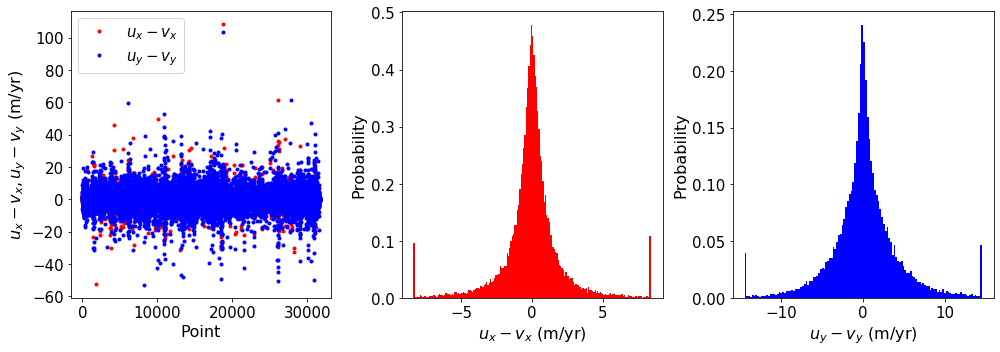

In [6]:
myCVPts.showDiffs(myVel, 0., 0.01)

**Figure 2. Results for bedrock points, showing left) raw differences,and 3-$\sigma$ clipped histograms for b) $u_x - v_x$ and c) $u_y - v_y$. The way the data are clipped means that the highest and lowest bins represent the probabilities for areas of the tails $|u-v| > 3\sigma$. As a result, values above 0.0013 indicates heaverier than Gaussian tails.** 

The differences *x*- and *y*-components ($u_x-v_x$ and $u_y-v_y$)  along with the corresponding histograms ($0.01 \leq \left| \vec{v} \right| < 20$) for the slow-moving points are calculated by:

In [7]:
muxSlow, muySlow, sigxSlow, sigySlow, rmsxSlow, rmsySlow, ngoodSlow, myTabSlow = myCVPts.vRangeStats(
    myVel, 0.01, 20, table=True)
myTabSlow

|Statistic|$u_x - v_x$ (m/yr)|$u_y - v_y$ (m/yr)|N points|
|------|------------|------------|---------|
|Mean|-0.32|0.079|7389|
|Std.Dev.|3.5|4.5|7389|
|rms|3.5|4.5|7389|

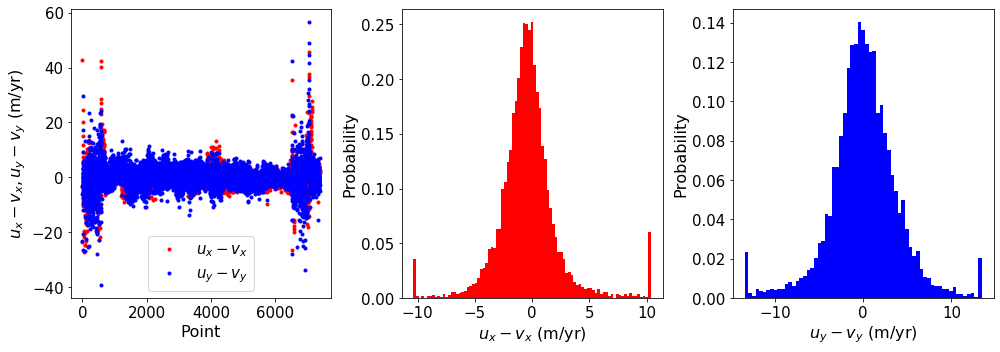

In [8]:
vxS,vyS,vvS,iGoodS=myCVPts.vRangeData(myVel,0.01,20)
myCVPts.showDiffs(myVel, 0.01, 20.)

**Figure 3. Results for slower points, showing left) raw differences,and 3-$\sigma$ clipped histograms for b) $u_x - v_x$ and c) $u_y - v_y$.**

The differences *x*- and *y*-components ($u_x-v_x$ and $u_y-v_y$)  along with the corresponding histograms $\left|\vec{v}\right| \geq 20$ for the fast-moving points are calculated by:

In [9]:
muxFast, muyFast, sigxFast, sigyFast, rmsxFast, rmsyFast, ngoodFast, myTabFast = myCVPts.vRangeStats(
    myVel, 20, 1000, table=True)
myTabFast

|Statistic|$u_x - v_x$ (m/yr)|$u_y - v_y$ (m/yr)|N points|
|------|------------|------------|---------|
|Mean|-0.65|0.35|84|
|Std.Dev.|6.1|8.2|84|
|rms|6.1|8.2|84|

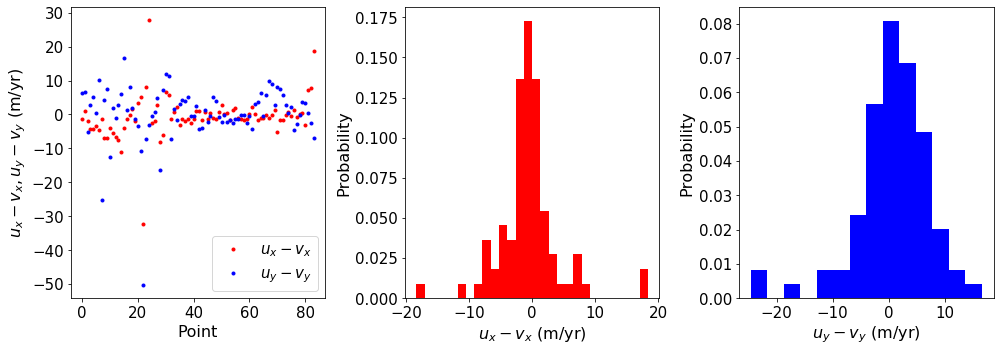

In [10]:
vxF, vyF, vvF, iGoodF = myCVPts.vRangeData(myVel, 20, 1000)
myCVPts.showDiffs(myVel, 20., 1000.)

**Figure 4. Results for faster points (v > 20), showing left) raw differences, and 3-$\sigma$ clipped histograms for b) $u_x - v_x$ and c)  $u_y - v_y$.**

The $3\sigma$ outliers for each set of points can be displayed over the velocity maps as follows:

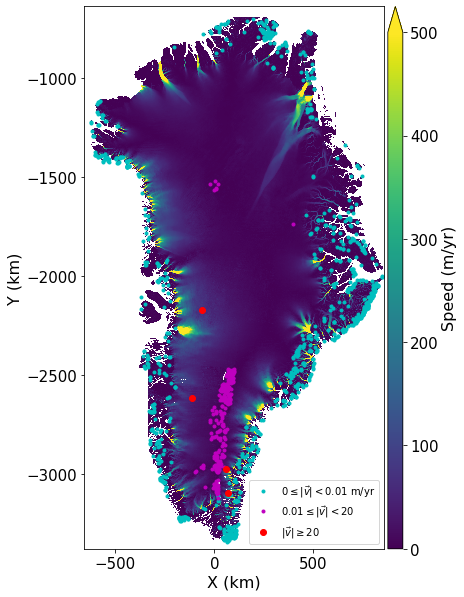

In [11]:
figOutlier, axOutlier = myVel.displayVel()
myCVPts.plotOutlierLocs(0, 0.01, myVel, nSig=3, ax=axOutlier, color='c', 
                        label='$0 \\leq \\left|\\vec{v} \\right| < 0.01$ m/yr')
myCVPts.plotOutlierLocs(0.01, 20., myVel, nSig=3, ax=axOutlier, color='m', 
                        label='$0.01 \\leq \\left| \\vec{v} \\right| < 20$')
myCVPts.plotOutlierLocs(20., 10000., myVel, nSig=3, ax=axOutlier, color='r',
                        label='$\\left|\\vec{v}\\right| \\geq 20$',markersize=12)
axOutlier.legend()

**Figure 5. Locations of 3$\sigma$ outliers for the bedrock, slow, and fast points.**